## Demonstrated Recreation of Florian2007 MSTDPET Rule

Credit to Sergio Chevtchenko
https://github.com/sergio-chevtchenko/reward-modulated-stdp-Florian2007/blob/master/MSTDPET_Fig_1.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from spikey.snn.synapse import RLSTDPET as SYNAPSE
from spikey.snn.neuron import Neuron

In [2]:
# Parameters from the paper
gamma = 0.2  # start learning rate
tau_z = 25  # stdp update aplication time
gamma_0 = gamma / tau_z  # Real learning rate
dt = 1  # change in time at every step
r = 1  # reward
z = 0  # Trace
P_pre = 0  # Track influence of presynaptic for z
P_pos = 0  # Track influence of postsnyaptic for z
tau_pre = 20 # window
tau_pos = 20 # window
A_pre = 1  # STDP scaling
A_pos = -1  # STDP scaling

In [3]:
# spike times of pre and post synaptic neurons
spike_times_post = [10, 70, 110, 140]
spike_times_pre = [5, 80, 115, 135]

# initial syaptic weight
w_mstdpet = w_mstdpet_ours = w_mstdp = w_stdp = 0.2

# traces for plotting
trace_fj = []
trace_fi = []
trace_P_pre =[]
trace_P_pos =[]
trace_zeta = []
trace_z = []
trace_r = []
trace_w_mstdpet = []
trace_w_mstdp = []
trace_w_stdp = []
trace_w_mstdpet_real = []
trace_w_mstdpet_ours = []

In [4]:
# simulation for 200 ms
for t in range(200):
    f_j = float(t in spike_times_pre)
    f_i = float(t in spike_times_post)
    
    # Equations 43 and 44 
    P_pre = P_pre * np.exp(-dt / tau_pre) + A_pre * f_j
    P_pos = P_pos * np.exp(-dt / tau_pos) + A_pos * f_i

    # Eq. 42
    zeta = P_pre * f_i + P_pos * f_j
    
    # Elegibility trace for MSTDPET (Eq. 8)
    z = z * np.exp(-dt / tau_z) + zeta 
    
    # Eq. 7
    w_mstdpet = w_mstdpet + gamma_0 * r * z

    # Append traces for later
    trace_fj.append(f_j)
    trace_fi.append(f_i)
    trace_P_pre.append(P_pre)
    trace_P_pos.append(P_pos)
    trace_zeta.append(zeta)
    trace_z.append(z)
    trace_r.append(r)
    trace_w_mstdpet_real.append(w_mstdpet)

    # As in Fig. 1, reward becomed negative after 100 ms
    if t > 100:
        r = -1

In [5]:
## Our RLSTDPET
config = {
    'n_neurons': 2,
    'n_inputs': 0,
    'stdp_window': 20,
    'learning_rate': .2 / 25,  # gamma_0 = gamma / Tau_z
    'trace_decay': 1,
}

class FakeWeight:
    def __init__(self):
        self._matrix = np.zeros((config['n_inputs'] + config['n_neurons'], config['n_neurons']))
        self.matrix = self._matrix

    def clip(self):
        pass

w = FakeWeight()
synapses = SYNAPSE(w, **config)
synapses.reset()

synapses.polarities = np.array([[1, 1], [1, 1]])

INHIBITORIES = np.array([1, 1])

LENGTH = 200
f_j = np.zeros(LENGTH)
f_i = np.zeros(LENGTH)

f_j[spike_times_pre] = 1.
f_i[spike_times_post] = 1.

full_spike_log = np.array([f_j, f_i]).T
trace = 0
for i in range(1, LENGTH):
    synapses.reward(1 if i <= 100 else -1)
    synapses.update(full_spike_log[:i], INHIBITORIES)

    w_mstdpet_ours += w.matrix[0, 1]
    trace_w_mstdpet_ours.append(w_mstdpet_ours)

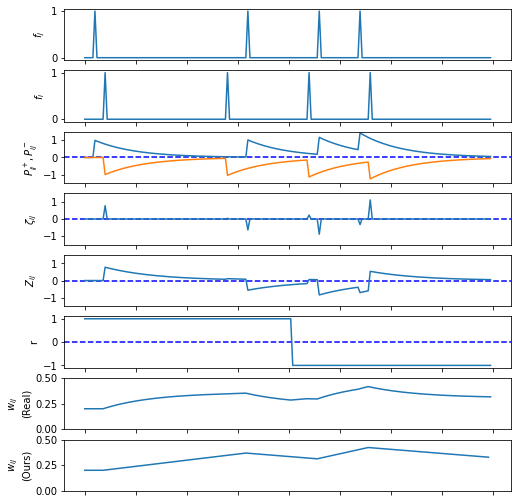

In [6]:
plt.rcParams['figure.figsize'] = [8, 10]

ax1 = plt.subplot(9, 1, 1)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.plot(trace_fj)
plt.ylabel(r'$f_j$')

ax2 = plt.subplot(9, 1, 2)
plt.setp(ax2.get_xticklabels(), visible=False)
plt.plot(trace_fi)
plt.ylabel(r'$f_i$')

ax3 = plt.subplot(9, 1, 3)
ax3.set_ylim([-1.5, 1.5])
plt.setp(ax3.get_xticklabels(), visible=False)
plt.axhline(linestyle='--', color='b')
plt.plot(trace_P_pre)
plt.plot(trace_P_pos)
plt.ylabel(r'$P_{ij}^+, P_{ij}^-$')

ax4 = plt.subplot(9, 1, 4, sharex=ax1)
ax4.set_ylim([-1.5, 1.5])
plt.setp(ax4.get_xticklabels(), visible=False)
plt.axhline(linestyle='--', color='b')
plt.plot(trace_zeta)
plt.ylabel(r'$\zeta_{ij}$')

ax5 = plt.subplot(9, 1, 5, sharex=ax1)
ax5.set_ylim([-1.5, 1.5])
plt.setp(ax5.get_xticklabels(), visible=False)
plt.axhline(linestyle='--', color='b')
plt.plot(trace_z)
plt.ylabel(r'$Z_{ij}$')

ax6 = plt.subplot(9, 1, 6, sharex=ax1)
plt.setp(ax6.get_xticklabels(), visible=False)
plt.axhline(linestyle='--', color='b')
plt.plot(trace_r)
plt.ylabel('r')

ax7 = plt.subplot(9, 1, 7, sharex=ax1)
ax7.set_ylim([0.0, 0.5])
plt.setp(ax7.get_xticklabels(), visible=False)
plt.plot(trace_w_mstdpet_real)
plt.ylabel(r'$w_{ij}$' + '\n' + '(Real)')

ax7 = plt.subplot(9, 1, 8, sharex=ax1)
ax7.set_ylim([0.0, 0.5])
plt.setp(ax7.get_xticklabels(), visible=False)
plt.plot(trace_w_mstdpet_ours)
plt.ylabel(r'$w_{ij}$' + '\n' + '(Ours)')

plt.show()